In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
# import all necessary libraries

import os
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import collections
from tqdm import tqdm_notebook as tqdm
from math import ceil, log, floor
from os import listdir

In [2]:
import cv2
import keras
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit
import sys

Using TensorFlow backend.


In [3]:
test_images_dir = "test/"
train_images_dir = "train/"

W0204 23:22:34.907551 20488 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


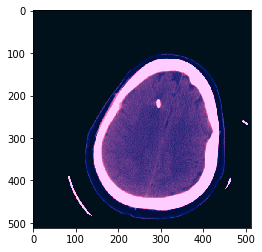

In [4]:
# preprocessing


def imp_dcm(dcm):
    x = dcm.pixel_array + 1000
    pix_mode = 4096
    x[x >= pix_mode] = x[x >= pix_mode] - pix_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000


def wind_image(dcm, wind_center, wind_width):

    if (
        (dcm.BitsStored == 12)
        and (dcm.PixelRepresentation == 0)
        and (int(dcm.RescaleIntercept) > -100)
    ):
        imp_dcm(dcm)

    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = wind_center - wind_width // 2
    img_max = wind_center + wind_width // 2
    img = np.clip(img, img_min, img_max)

    return img


def bsb_wind(dcm):

    brain_img = wind_image(dcm, 50, 100)
    subdural_img = wind_image(dcm, 100, 220)
    soft_img = wind_image(dcm, 60, 390)
    brain_img = (brain_img - 0) / 100
    subdural_img = (subdural_img - (-30)) / 300
    soft_img = (soft_img - (-180)) / 400
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1, 2, 0)

    return bsb_img


dicom = pydicom.dcmread(train_images_dir + "ID_76d0b8293" + ".dcm")

plt.imshow(bsb_wind(dicom), cmap=plt.cm.bone)

W0204 23:22:35.139929 20488 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


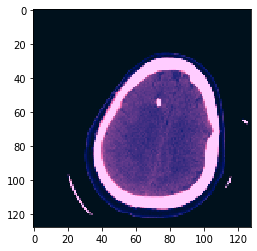

In [5]:
# Helper functions
def read(path, preferred_size):

    dcm = pydicom.dcmread(path)

    try:
        img = bsb_wind(dcm)
    except:
        img = np.zeros(preferred_size)

    img = cv2.resize(img, preferred_size[:2], interpolation=cv2.INTER_LINEAR)

    return img


# check
plt.imshow(
    read(train_images_dir + "ID_76d0b8293" + ".dcm", (128, 128)), cmap=plt.cm.bone
)

In [6]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_ids, labels = None, batch_size = 1, img_size = (512, 512, 1), img_dir = train_images_dir, *args, **kwargs):

        self.list_ids = list_ids
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):

        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_ids_tmp = [self.list_ids[k] for k in indices]

        if self.labels is not None:
            X, Y  = self.__data_generation(list_ids_tmp)
            return X, Y
        else:
            X = self.__data_generation(list_ids_tmp)
            return X

    def on_epoch_end(self):

        if self.labels is not None:

            keep_prob = self.labels.iloc[:,0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_ids))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_ids))

    def __data_generation(self, list_ids_tmp):


        X = np.empty((self.batch_size, *self.img_size))

        if self.labels is not None:
            Y = np.empty((self.batch_size, 6), dtype = np.float32)

            for i, tmp_id in enumerate(list_ids_tmp):
                X[i, ] = read(self.img_dir + tmp_id + ".dcm", self.img_size)
                Y[i, ] = self.labels.loc[tmp_id].values

            return X, Y

        else:
            for i, tmp_id in enumerate(list_ids_tmp):
                X[i,] = read(self.img_dir + tmp_id + ".dcm", self.img_size)
            return X



In [7]:
# DataGenerator()

In [8]:
# Loss functions and metrics

from keras import backend as K 

def weighted_log_loss(y_true, y_pred):

    class_weights = np.array([2., 1., 1., 1., 1., 1.])

    eps = K.epsilon()

    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -( y_true * K.log(y_pred) * class_weights + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)

    return K.mean(out, axis=-1)

def normalized_weighted_avg(arr, weights = None):
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis = 1)
        return K.sum(K.dot(arr, weights), axis = 1) / scl
    return K.mean(arr, axis = 1)

def weighted_loss(y_true, y_pred):
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])

    eps = K.epsilon()

    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))

    loss_samples = normalized_weighted_avg(loss, class_weights)

    return K.mean(loss_samples)

def weighted_loss_metric(actual, pred):

    class_weights = [2., 1., 1., 1., 1., 1.]

    epsilon = 1e-7

    preds = np.clip(pred, epsilon, 1-epsilon)
    loss = actual * np.log(pred) + (1 - actual) * np.log(1 - pred)
    loss_samples = np.average(loss, axis= 1, weights = class_weights)

    return - loss_samples.mean()




In [9]:
# Model

class PredictionCheckpoint(keras.callbacks.Callback):

    def __init__(self, test_df, valid_df, test_images_dir = test_images_dir, valid_images_dir = train_images_dir, batch_size = 32, input_size = (224, 224, 3)):

        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size

    def on_train_begin(self, logs = {}):
        self.test_predictions = []
        self.valid_predictions = []
    
    def on_epoch_end(self,batch, logs = {}):
        self.test_predictions.append(self.model.predict_generator(DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir), verbose = 2)[:len(self.test_df)])


class DLmodel:
    

    def __init__(self, engine, input_dims, batch_size = 5, num_epochs = 4, learning_rate = 1e-3, decay_rate = 1.0, decay_steps = 1, weights = "imagenet", verbose = 1):

        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self.build()

    def build(self):

        engine = self.engine(include_top = False, weights = self.weights, input_shape = self.input_dims, backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)

        x = keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)

        out = keras.layers.Dense(6, activation = "sigmoid", name = 'dense_output')(x)

        self.model = keras.models.Model(inputs = engine.input, outputs = out)

        self.model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(), metrics = [weighted_loss])

    def fit_predict(self, train_df, valid_df, test_df):

        pred_hist = PredictionCheckpoint(test_df, valid_df, input_size = self.input_dims)

        scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))

        self.model.fit_generator(DataGenerator(train_df.index, train_df, self.batch_size, self.input_dims, train_images_dir),
                               epochs = self.num_epochs,
                               verbose = self.verbose,
                               use_multiprocessing = False,
                               workers=4,
                               callbacks=[pred_hist, scheduler]
        )

        return pred_hist

    def save(self, path):
        self.model.save_weights(path)

    def load(self, path):
        self.model.load_weights(path)




In [10]:
# ss = pd.read_csv("train_df.csv")
# aa = ss[ss.duplicated()]

In [11]:
# aa.index

In [12]:
def read_train_data(filename="train_df.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)

    dup = df[df.duplicated()].index.tolist()

    df = df.drop(index=dup)
    df = df.reset_index(drop=True)

    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(["Image", "Diagnosis"]).unstack(level=-1)

    return df


def read_test_data(filename="test_df.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)

    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(["Image", "Diagnosis"]).unstack(level=-1)

    return df


test_df = read_test_data()
train_df = read_train_data()

In [13]:
train_df.head()

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0

In [14]:
# choosing only 10% of the data to build the prototype
proto_train_df = train_df.iloc[350000:430000]

In [15]:
proto_test_df = test_df.iloc[70000:82500]

In [16]:
# train_df.Label.value_counts()

In [17]:
# get index for all files
train_index = proto_train_df.index.tolist()
test_index = proto_test_df.index.tolist()

In [18]:
# copy all corresponding files
import shutil
import os

In [64]:
tst_dir = "E:/Springboard-Capstone/stage_2_test_images/"
for f in test_index:
    shutil.copy(os.path.join(tst_dir, f + ".dcm"), "test/")

<IPython.core.display.Javascript object>

In [65]:
trn_dir = "E:/Springboard-Capstone/stage_2_train_images/"
for l in train_index:
    shutil.copy(os.path.join(trn_dir, l + ".dcm"), "train/")

<IPython.core.display.Javascript object>

In [19]:
# Training Model

shuffle = ShuffleSplit(n_splits = 10, test_size = 0.1, random_state = 42).split(proto_train_df.index)

train_idx, vali_idx = next(shuffle)

# get model
model = DLmodel(engine = InceptionV3, input_dims = (256, 256, 3), batch_size = 32, learning_rate = 5e-4, num_epochs = 5, decay_rate = 0.8, decay_steps = 1, weights = "imagenet", verbose = 1)

hist = model.fit_predict(proto_train_df.iloc[train_idx], proto_train_df.iloc[vali_idx], proto_test_df)

Epoch 1/5


FailedPreconditionError: Error while reading resource variable _AnonymousVar385 from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/_AnonymousVar385/class tensorflow::Var does not exist.
	 [[{{node metrics/weighted_loss/Sum/ReadVariableOp}}]] [Op:__inference_keras_scratch_graph_72982]